<a href="https://colab.research.google.com/github/kalmuroth/lb-cml/blob/main/lb_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Random Forest for Fraud Detection with SciKit-Learn

In [26]:
!pip install h2o

In [27]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import h2o
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphj1pe7xd
  JVM stdout: /tmp/tmphj1pe7xd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphj1pe7xd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_m7gg4u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [28]:
data = pd.read_csv('./drive/MyDrive/notebook/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [29]:
address2country = pd.read_csv('./drive/MyDrive/notebook/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [30]:
# Merge the two datasets based on IP address range
merged_data = pd.concat([data, address2country], axis=1)
print(merged_data.head())

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   

   lower_bound_ip_address  upper_bound_ip_address    country  
0              16777216.0              16777471.0  Australia  
1              16777472.0              16777727.0      China  

In [31]:
# Get the time difference between purchase time and signup time
merged_data['time_difference'] = merged_data['purchase_time'] - merged_data['signup_time']

# Create a new DataFrame with selected columns
new_dataframe = merged_data[['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source',
                             'browser', 'sex', 'age', 'ip_address', 'class', 'country', 'time_difference']]

# Print the first 5 rows of the new DataFrame
print(new_dataframe.head())


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class    country  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  Australia   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0      China   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1      China   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  Australia   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0      China   

   time_difference  
0 52 days 03:51:22  
1  0 days 04:59:04  
2  0 days 00:00:01  
3  5 days 16:41:25  
4 50 days 11:31:0

In [32]:
# Check user number for unique devices
unique_devices_per_user = merged_data.groupby('user_id')['device_id'].nunique()
print(unique_devices_per_user)

user_id
2         1
4         1
8         1
9         1
12        1
         ..
399992    1
399993    1
399995    1
399997    1
400000    1
Name: device_id, Length: 151112, dtype: int64


In [33]:
# Check user number for unique ip_address
unique_ips_per_user = merged_data.groupby('user_id')['ip_address'].nunique()
print(unique_ips_per_user)

user_id
2         1
4         1
8         1
9         1
12        1
         ..
399992    1
399993    1
399995    1
399997    1
400000    1
Name: ip_address, Length: 151112, dtype: int64


In [34]:
# Signup day and week
# Purchase day and week
merged_data['signup_day'] = merged_data['signup_time'].dt.day_name()
merged_data['signup_week'] = merged_data['signup_time'].dt.isocalendar().week

# Extract purchase day and week
merged_data['purchase_day'] = merged_data['purchase_time'].dt.day_name()
merged_data['purchase_week'] = merged_data['purchase_time'].dt.isocalendar().week

# Print the first 5 rows with the new columns
print(merged_data[['user_id', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week']].head())

   user_id signup_day  signup_week purchase_day  purchase_week
0    22058    Tuesday            9     Saturday             16
1   333320     Sunday           23       Monday             24
2     1359   Thursday            1     Thursday              1
3   150084    Tuesday           18       Monday             19
4   221365    Tuesday           30    Wednesday             37


In [35]:
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,16777216.0,16777471.0,Australia,52 days 03:51:22,Tuesday,9,Saturday,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,16777472.0,16777727.0,China,0 days 04:59:04,Sunday,23,Monday,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,16777728.0,16778239.0,China,0 days 00:00:01,Thursday,1,Thursday,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,16778240.0,16779263.0,Australia,5 days 16:41:25,Tuesday,18,Monday,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,16779264.0,16781311.0,China,50 days 11:31:01,Tuesday,30,Wednesday,37


In [36]:
# Define features and target to be used
features = ['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_difference', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week']
target = 'class'

X = merged_data[features]
y = merged_data[target]

merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,16777216.0,16777471.0,Australia,52 days 03:51:22,Tuesday,9,Saturday,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,16777472.0,16777727.0,China,0 days 04:59:04,Sunday,23,Monday,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,16777728.0,16778239.0,China,0 days 00:00:01,Thursday,1,Thursday,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,16778240.0,16779263.0,Australia,5 days 16:41:25,Tuesday,18,Monday,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,16779264.0,16781311.0,China,50 days 11:31:01,Tuesday,30,Wednesday,37


In [37]:
from sklearn.model_selection import train_test_split
# Split into 70% training and 30% test dataset
# Define features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shape of training and test sets
print("Training set shape - X_train:", X_train.shape, "y_train:", y_train.shape)

print("Test set shape - X_test:", X_test.shape, "y_test:", y_test.shape)

Training set shape - X_train: (105778, 11) y_train: (105778,)
Test set shape - X_test: (45334, 11) y_test: (45334,)


In [38]:
# Build random forest model
features = ['purchase_value', 'age', 'time_difference', 'signup_week', 'purchase_week',
            'source', 'browser', 'sex', 'country', 'signup_day', 'purchase_day']
predictors = features

target = 'class'

# Convert the pandas DataFrame to H2O frame
h2o_df = h2o.H2OFrame(merged_data)

# Split the dataset into training and test sets (70% training, 30% test)
train, test = h2o_df.split_frame(ratios=[0.7], seed=42)

drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=predictors, y=target, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1693485644386_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          2.71932e+06            20           20           20            2178          3899          3141.42

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.043266363811053525
RMSE: 0.20800568216049659
MAE: 0.08364998492918854
RMSLE: 0.1468695746146962
Mean Residual Deviance: 0.043266363811053525

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0425214743630114
RMSE: 0.20620735768398615
MAE: 0.08376001060721419
RMSLE: 0.14474907487962774
Mean Residual Deviance: 0.0425214743630114

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.0837573  0.00164452  0.0842948     0.0843524     0.0853662     0.0837295     0.0853075     0.0806919     0.0842712     0.0855005     0.0821594     0.0818995
mean_residual_deviance  0.042518   0.00159108  0.0430961     0.0428369     0.0437973     0.0430346     0.0437095     0.0392954     0.0432522     0.0442813     0.0409253     0.0409512
mse                     0.042518   0.00159108  0.0430961     0.0428369     0.0437973     0.0430346     0.0437095     0.0392954     0.0432522     0.0442813     0.0409253     0.0409512
r2                      0.497784   0.0113983   0.483165      0.492219      0.493952      0.490755      0.491961      0.514008      0.498647      0.489275      0.518642      0.505213
residual_deviance       0.042518   0.00159108  0.0430961     0.0428369     0.0437973     0.0430346     0.0437095     0.0392954     0.0432522     0.0442813     0.0409253     0.0409512
rmse                    0.206166   0.00389108  0.207596      0.206971      0.209278      0.207448      0.209068      0.198231      0.207972      0.210431      0.2023        0.202364
rmsle                   0.144723   0.0025613   0.145606      0.145327      0.146922      0.145588      0.146557      0.139516      0.145727      0.147576      0.142179      0.14223

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2023-08-31 12:45:39  4 min  7.571 sec  0                  nan              nan             nan
    2023-08-31 12:45:40  4 min  8.496 sec  1                  0.244444         0.0826859       0.0597531
    2023-08-31 12:45:41  4 min  9.455 sec  2                  0.248589         0.0827915       0.0617964
    2023-08-31 12:45:41  4 min 10.376 sec  3                  0.243836         0.0831154       0.0594561
    2023-08-31 12:45:42  4 min 11.205 sec  4                  0.242237         0.0833755       0.0586786
    2023-08-31 12:45:46  4 min 15.240 sec  14                 0.217153         0.0835518       0.0471555
    2023-08-31 12:45:51  4 min 19.425 sec  27                 0.210805         0.0835276       0.0444389
    2023-08-31 12:45:55  4 min 23.506 sec  38                 0.209057         0.0836728       0.0437048
    2023-08-31 12:45:59  4 min 27.774 sec  47                 0.208183         0.0836219       0.04334
    2023-08-31 12:46:00  4 min 28.754 sec  50                 0.208006         0.08365         0.0432664

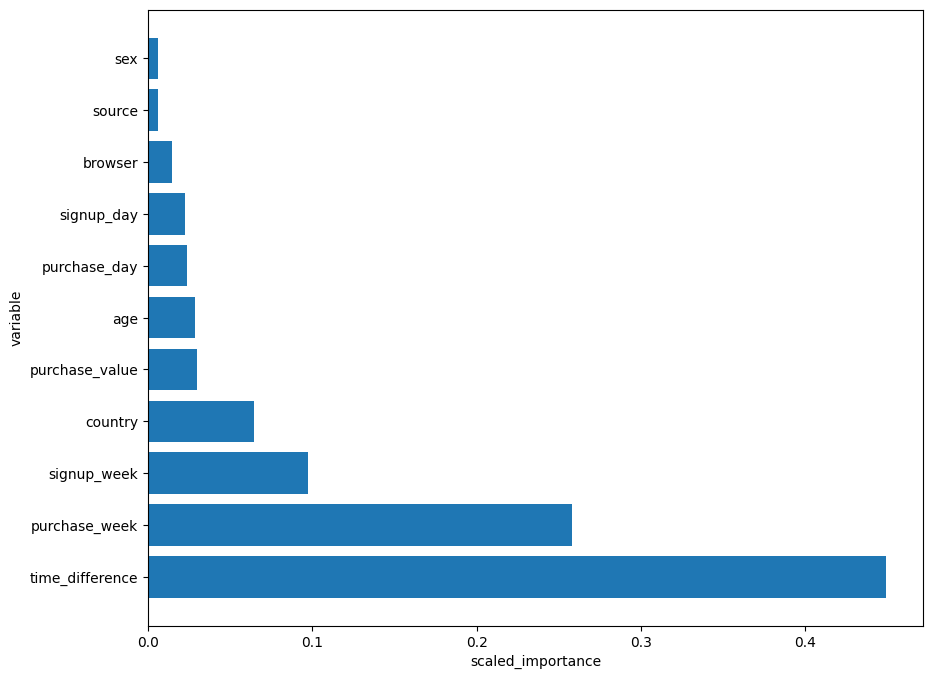

In [39]:
# Feature importance
feature_imp = drf.varimp(use_pandas=True)
feature_imp = feature_imp.sort_values(by='percentage', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['variable'], feature_imp['percentage'])
plt.xlabel('scaled_importance')
plt.ylabel('variable')
plt.savefig("Importances.png")

In [77]:
# Classification report
y_true_train = train['class'].as_data_frame()

y_pred = drf.predict(test).as_data_frame()
y_true = test['class'].as_data_frame()
threshold = 0.5
y_pred['pred_class'] = (y_pred['predict'] > threshold).astype(int)
report = classification_report(y_true['class'], y_pred['pred_class'])
print(report)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     40919
           1       1.00      0.55      0.71      4260

    accuracy                           0.96     45179
   macro avg       0.98      0.77      0.84     45179
weighted avg       0.96      0.96      0.95     45179



drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


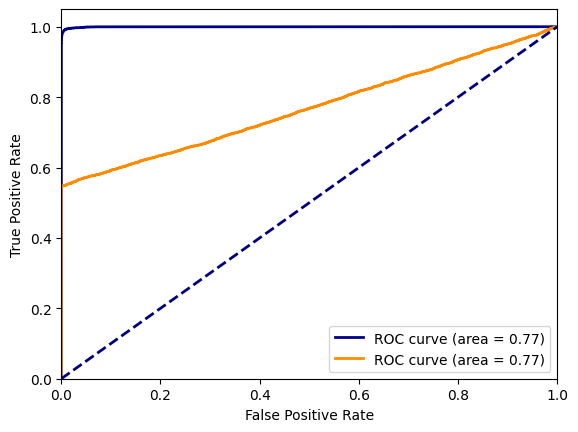

In [78]:
# Build random forest model
from sklearn import metrics

y_test_probs = drf.predict(test).as_data_frame()['predict']
fpr, tpr, _ = roc_curve(y_true['class'], y_test_probs)
roc = metrics.auc(fpr, tpr)

y_train_probs = drf.predict(train).as_data_frame()['predict']
fpr_train, tpr_train, _ = roc_curve(y_true_train['class'], y_train_probs)
roc_train = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_train)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig("ROC_Fraud.png")
